Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.  
Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.   
Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.  

Задание 3: использовать permutation importance, выполнить задание 1 и 2.  
Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.  
Задание 5: использовать shap, выполнить задание 1 и 2.  
Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.  

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn import metrics
import seaborn as sns
import warnings
from tqdm import tqdm
from typing import List, Tuple
from scipy.stats import ttest_rel
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from classes_and_functions import bootstrap_calculate_confidence_interval, make_cross_validation,make_cross_validation_gr
from boostaroota import BoostARoota
import shap
from sklearn.inspection import permutation_importance
%matplotlib inline
warnings.filterwarnings("ignore")
shap.initjs()

In [3]:
# train= pd.read_csv('train.csv')
# train.set_index('TransactionID',inplace=True)

In [4]:
w_train = pd.read_csv('w_train.csv')

In [5]:
w_train.shape

(180000, 432)

In [6]:
object_features = w_train.select_dtypes(include=[np.object]).columns
w_train[object_features]= w_train[object_features].astype('category')

In [7]:
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train.drop('isFraud',axis=1),w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])

In [8]:
scors= pd.DataFrame()

In [9]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    'num_leaves':45,
    'max_depth':4,
    'learning_rate':0.1,
    'n_estimators':5000,
    "metric": "auc",
    "n_jobs": 15,
    'reg_alpha':2,
    'reg_lambda':2,
    "random_state": 30,
#     'device':"gpu"
}

In [10]:
model = lgb.LGBMClassifier(**params)

In [11]:
%%time
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['base','auc'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

Wall time: 20.8 s


(1030,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9985071309797477)]),
              'valid_1': OrderedDict([('auc', 0.9507084266635097)])}))

### Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [12]:
important_features = pd.DataFrame()
important_features['name'] = model.feature_name_
important_features['importances'] = model.feature_importances_
important_features.sort_values('importances',ascending = False, inplace = True)  
important_features.head(25)

,name,importances
399,card1_card2_card_3_card_5_addr1_addr2,2369
397,card1_card2,943
398,card1_card2_card_3_card_5,579
394,day,348
3,card1,336
429,TransactionAmt_float,255
43,D15,224
27,C13,222
395,hour,213
36,D8,198


In [13]:
important_features.tail(25)

,name,importances
307,V255,0
324,V272,0
339,V287,0
340,V288,0
349,V297,0
247,V195,0
242,V190,0
170,V118,0
240,V188,0
171,V119,0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

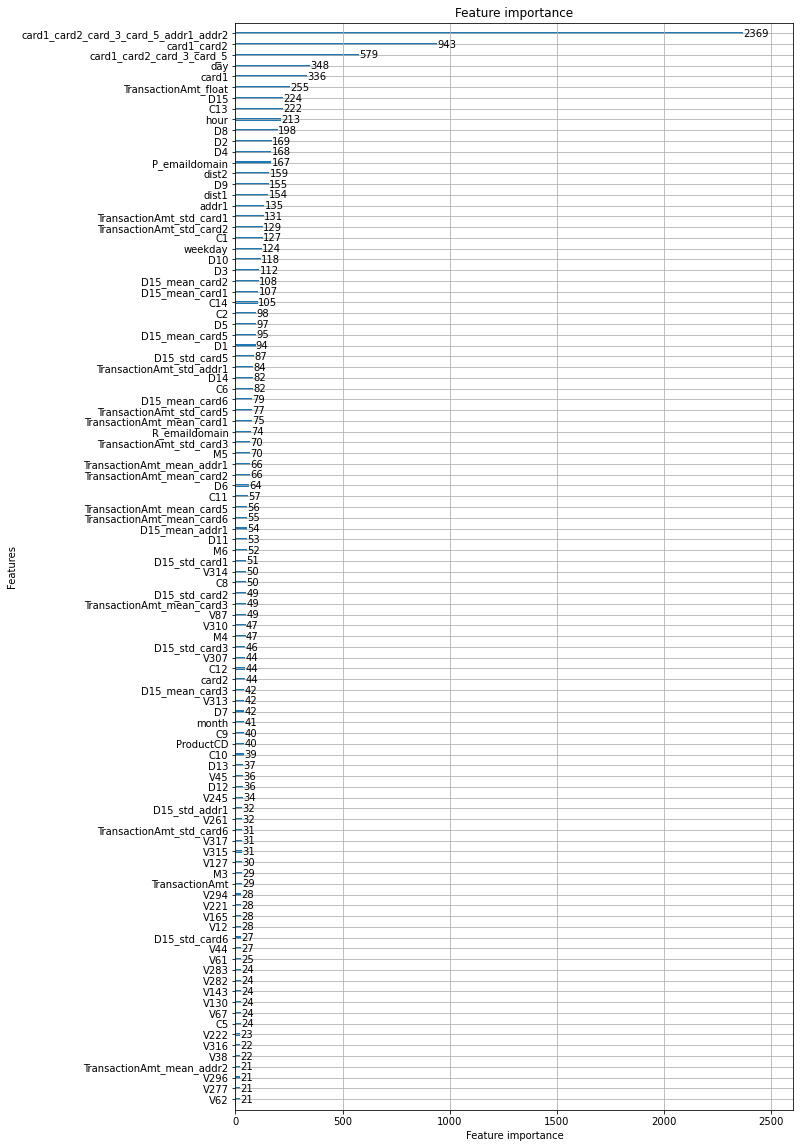

In [14]:
lgb.plot_importance(model,figsize=(10,20),max_num_features = 100)


### Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [15]:
my_features = important_features[important_features.importances>=1].name.to_list()
len(my_features)

341

In [16]:
%%time
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train[my_features],w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['job_2'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

Wall time: 18.9 s


(1030,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9985071309797477)]),
              'valid_1': OrderedDict([('auc', 0.9507122095675429)])}))

### Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [17]:
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train.drop('isFraud',axis=1),w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
model.best_iteration_,model.best_score_


(1030,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9985071309797477)]),
              'valid_1': OrderedDict([('auc', 0.9507084266635097)])}))

In [18]:
%%time
importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=14, random_state=27
)

Wall time: 21min 53s


In [19]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
importance_scores

,features,importance-mean,importance-std
0,card1_card2_card_3_card_5_addr1_addr2,0.053377,0.001578
1,card1,0.005220,0.000760
2,C13,0.004585,0.000674
3,C14,0.003974,0.000465
4,C1,0.003796,0.000397
...,...,...,...
426,V127,-0.000115,0.000081
427,V317,-0.000148,0.000171
428,M8,-0.000205,0.000042
429,C5,-0.000262,0.000177


<AxesSubplot:ylabel='features'>

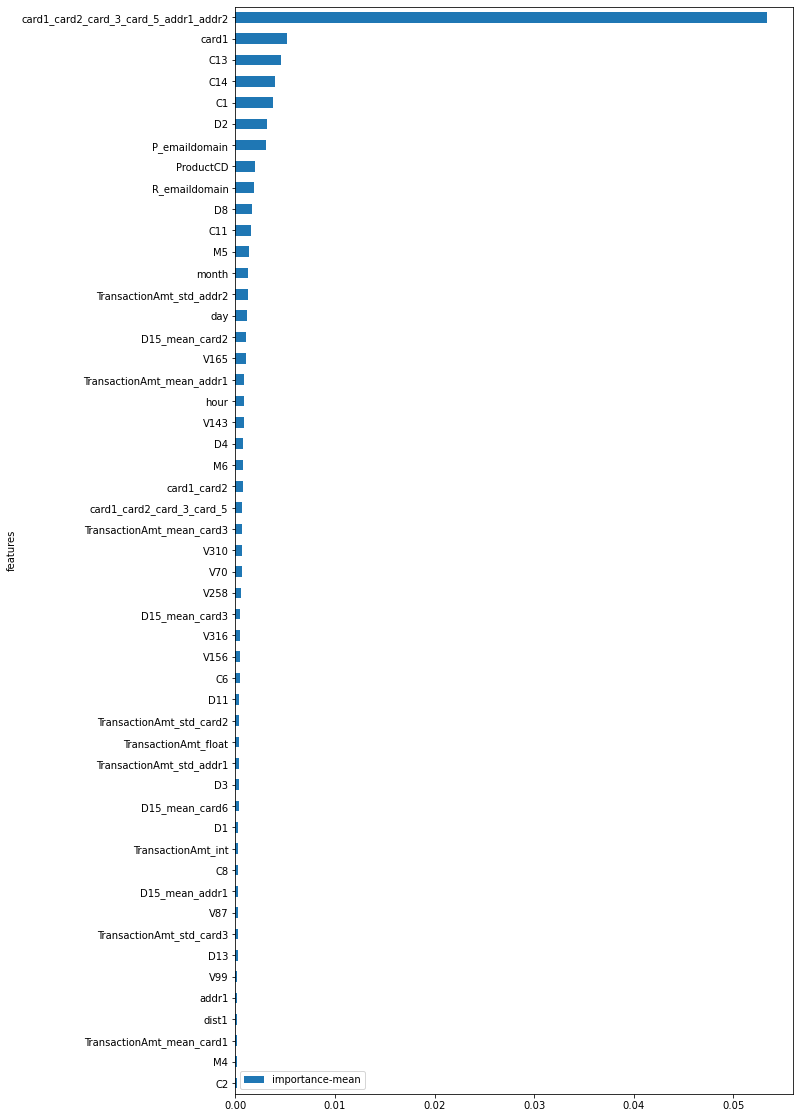

In [20]:
importance_scores.loc[:50].sort_values('importance-mean').plot.barh('features','importance-mean',figsize = (10,20))

In [21]:
my_features = importance_scores[importance_scores['importance-mean']>=0.00001].features.to_list()
len(my_features)

137

In [22]:
%%time
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train[my_features],w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['job_3'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

Wall time: 15.4 s


(1241,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9989380282526709)]),
              'valid_1': OrderedDict([('auc', 0.9517330929779955)])}))

### Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [23]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="category"].index.tolist()
    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

In [24]:
for i in object_features:
    print(i,w_train[i].nunique())

TransactionDT 173460
ProductCD 5
card4 4
P_emaildomain 59
R_emaildomain 60
M1 2
M2 2
M3 2
M4 3
M5 2
M6 2
M7 2
M8 2
M9 2
card1_card2 9636
card1_card2_card_3_card_5 9771
card1_card2_card_3_card_5_addr1_addr2 25887


Я в замешательстве что делать с самыми лучшими признаками. Они категориальные, но их количесто огромное, поетомиу OHE сделает талицу огромной. Придеться их убрать

In [25]:
%%time
data = prepare_data(w_train.drop(['isFraud','TransactionDT','card1_card2',\
                                  'card1_card2_card_3_card_5','card1_card2_card_3_card_5_addr1_addr2' ],axis=1))
data.shape

Wall time: 339 ms


(180000, 561)

In [26]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data=data.fillna(-999999)

In [27]:
x_train,x_valid,y_train,y_valid =\
train_test_split(data,w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])

In [28]:
%%time
br = BoostARoota(metric='auc', iters=10,cutoff = 4,max_rounds = 100)
br.fit(x_train, y_train)

[22:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[22:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[22:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due 

Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.
Wall time: 2min 2s


In [29]:
br.keep_vars_

0      transactionamt
1               card1
2               card2
3               card3
4               card5
            ...      
293             m4_m0
294             m4_m2
295              m5_f
296              m5_t
297              m6_f
Name: feature, Length: 274, dtype: object

In [30]:
w_train_br = br.transform(data)

In [31]:
%%time
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train_br, w_train['isFraud'],test_size = 0.2,random_state=30)
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['job_4'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

Wall time: 18.4 s


(1287,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9937390052602079)]),
              'valid_1': OrderedDict([('auc', 0.9483724805678968)])}))

### Задание 5: использовать shap, выполнить задание 1 и 2.

In [32]:
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train.drop('isFraud',axis=1),w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])

In [33]:
model = lgb.LGBMClassifier(**params)
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['base','auc'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

(1030,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9985071309797477)]),
              'valid_1': OrderedDict([('auc', 0.9507084266635097)])}))

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)[0]

In [35]:
shap.force_plot(
    explainer.expected_value[0], shap_values[0,:], x_valid.iloc[0,:], link="logit"
)

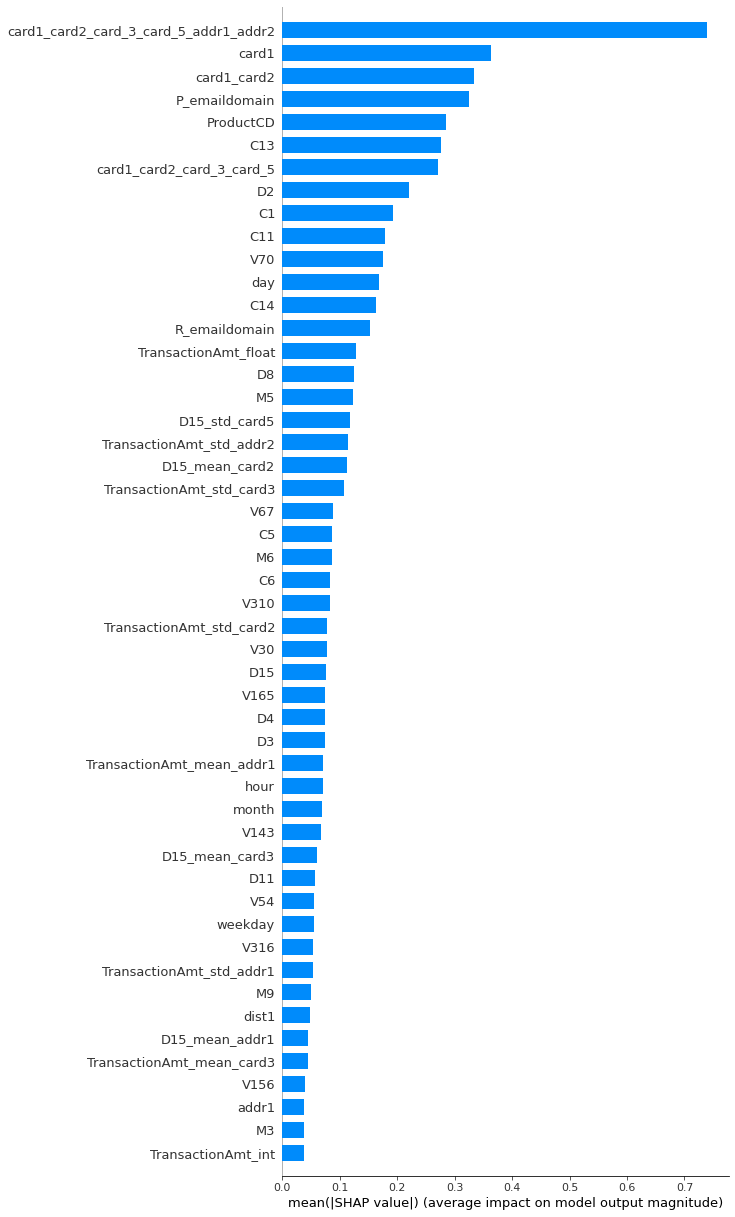

In [36]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=50)

In [37]:
res = pd.DataFrame()
res['f'] = x_valid.columns.to_list()
res['im'] = np.abs(shap_values).mean(axis = 0)
res.sort_values('im',ascending=False,inplace = True)
res

,f,im
399,card1_card2_card_3_card_5_addr1_addr2,0.739755
3,card1,0.363136
397,card1_card2,0.333761
13,P_emaildomain,0.324493
2,ProductCD,0.285260
...,...,...
227,V175,0.000000
229,V177,0.000000
234,V182,0.000000
235,V183,0.000000


In [38]:
my_f = res[res.im>0.0005].f.to_list()
len(my_f)

255

In [39]:
x_train,x_valid,y_train,y_valid =\
train_test_split(w_train[my_f],w_train['isFraud'], test_size = 0.2,random_state=30,stratify =w_train['isFraud'])

In [40]:
model = lgb.LGBMClassifier(**params)
model.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)
scors.loc['job_5','auc'] = model.best_score_['valid_1']['auc']
model.best_iteration_,model.best_score_

(1323,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9992399426016516)]),
              'valid_1': OrderedDict([('auc', 0.9508037224665781)])}))

#### Результаты всех заданий

In [41]:
scors

,auc
base,0.950708
job_2,0.950712
job_3,0.951733
job_4,0.948372
job_5,0.950804


### Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [64]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)[0]
expected_value = explainer.expected_value[1]




# select = range(20)
# features = x_valid.iloc[select]
# features_display = x_valid.loc[features.index]
# shap_values = explainer.shap_values(features)
# shap_interaction_values = explainer.shap_interaction_values(features)

# if isinstance(shap_interaction_values, list):
#     shap_interaction_values = shap_interaction_values[1]

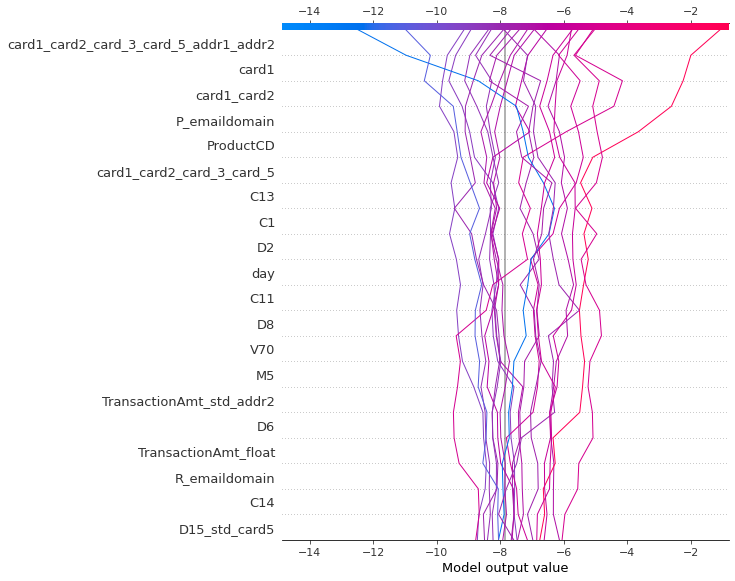

In [67]:
shap.decision_plot(
    expected_value, shap_values[:20], x_valid.loc[:20]
)

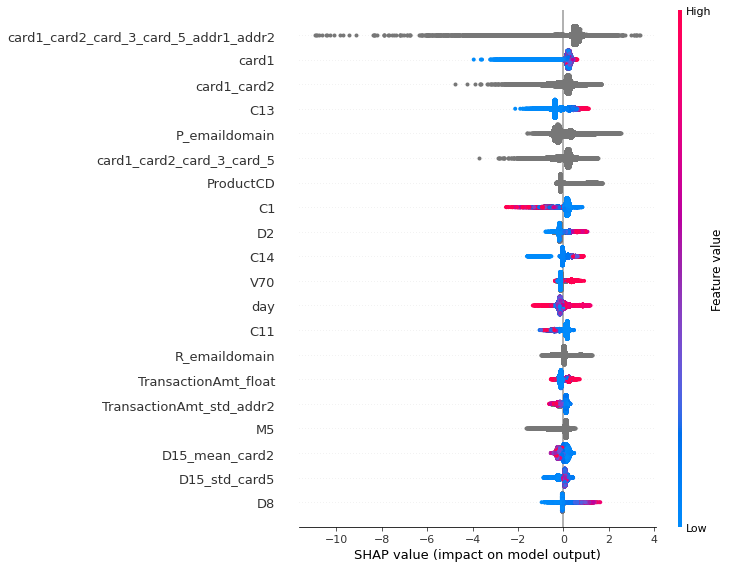

In [69]:
shap.summary_plot(shap_values, x_valid)